In [1]:
import pickle
import torch
import matplotlib.pyplot as plt

from pkasolver.constants import DEVICE
from pkasolver.data import calculate_nr_of_features
from pkasolver.ml import (
    dataset_to_dataloader,
    calc_testset_performace,
    calculate_performance_of_model_on_data,
)
from pkasolver.ml_architecture import GINPairV1, GINPairV2
from scipy.stats import t
# from pkasolver.stat import calc_stat_info

# from pytorch_model_summary import summary
from rdkit.Chem.PandasTools import SaveXlsxFromFrame
from pkasolver.data import preprocess

import seaborn as sns
import numpy as np
sns.set_context("paper", font_scale=2)

BATCH_SIZE = 512
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

node_feat_list = [
    "element",
    "formal_charge",
    "hybridization",
    "total_num_Hs",
    "aromatic_tag",
    "total_valence",
    "total_degree",
    "is_in_ring",
    "reaction_center",
    "smarts",
]

edge_feat_list = ["bond_type", "is_conjugated", "rotatable"]
num_node_features = calculate_nr_of_features(node_feat_list)
num_edge_features = calculate_nr_of_features(edge_feat_list)

Setting num threads to 1
Pytorch will use cuda


In [2]:
def confidence_calculation(sample_list):
    x = np.array(sample_list)
    m = x.mean()
    s = x.std()
    dof = len(x) - 1
    confidence = 0.95
    t_crit = np.abs(t.ppf((1 - confidence) / 2, dof))
    return (
        m,
        s * t_crit / np.sqrt(len(x)),
    )

# def error_list(x, y):
#     errors = abs(y - x)
#     # rep = len(args.model)
#     rep = 10
#     num_samples = int(len(errors) / rep)
#     errors_2d = np.reshape(errors, (rep, num_samples))
#     pred_2d = np.reshape(y, (rep, num_samples))
#     return np.mean(errors_2d, axis=0), np.mean(pred_2d, axis=0)


# def error_df(path, error_list, pred_list, name):
#     df = preprocess(path)
#     df.insert(loc=0, column="prediction_error", value=error_list)
#     df.insert(loc=0, column="pkasolver-pka", value=pred_list)
#     df.sort_values(by="prediction_error", ascending=False, inplace=True)
#     for mol, atom in zip(df.protonated, df.marvin_atom):
#         mol.__sssAtoms = [int(atom)]
#     SaveXlsxFromFrame(df, f"{name}.xlsx", molCol="protonated")

def plot_results(x_col, y_col):
    # Define plot canvas
    g = sns.jointplot(
        x=x_col,
        y=y_col,
        xlim=(2, 12),
        ylim=(2, 12),
        kind="reg",
    )

    # Add fit_reg lines to plot
    sns.regplot(x=x_col, y=y_col, scatter=False, ax=g.ax_joint, truncate=False)
    # Add Diagonal line to Joint axes
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = np.array([max(x0, y0), min(x1, y1)])
    g.ax_joint.plot(lims, lims, "-r")
    # Add error band of pka ± 1
    g.ax_joint.fill_between(lims, lims - 1, lims + 1, color="r", alpha=0.2)
    g.ax_joint.errorbar(x_array, y_array, y_error, fmt="none", capsize=2, capthick=1, ecolor="red")
    return g


In [3]:
data_path = "/data/shared/projects/pkasolver-data-clean"
model_path = f"{data_path}/trained_models_v2/training_with_GINPairV1_v1_hp"
# test_path = f"{data_path}/05_novartis_testdata.pkl"
test_path = f"{data_path}/05_AvLiLuMoVe_testdata.pkl"
# name = "pretrained_GINPairV1_hp_novartis"
name = "pretrained_GINPairV1_hp_literature"
modelpaths = [f"{data_path}/trained_models_v0/training_with_GINPairV1_v{i}_hp/pretrained_best_model.pt" for i in range(10)]

# decide wheter to split training set or use explicit validation set
print(f"load test dataset from: {test_path}")
# read training set
with open(test_path, "rb") as f:
    test_dateset = pickle.load(f)
test_loader = dataset_to_dataloader(test_dateset, BATCH_SIZE, shuffle=False)

if name.__contains__("V1"):
    model_name, model_class = "GINPairV1", GINPairV1
elif name.__contains__("V2"):
    model_name, model_class = "GINPairV2", GINPairV2

load test dataset from: /data/shared/projects/pkasolver-data-clean/05_AvLiLuMoVe_testdata.pkl


In [4]:
mae, rmse, r2 = [], [], []
for i, model_path in enumerate(modelpaths):
    if name.__contains__("hp"):
        model = model_class(
            num_node_features, num_edge_features, hidden_channels=96
        )
    if name.__contains__("lp"):
        model = model_class(
            num_node_features, num_edge_features, hidden_channels=64
        )
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    model.to(device=DEVICE)
    MAE, RMSE, R2 = calc_testset_performace(model, test_loader)
    mae.append(MAE)
    rmse.append(RMSE)
    r2.append(R2)
    x, y = calculate_performance_of_model_on_data(model, test_loader)
    if i > 0:
        x_array = np.vstack((x_array, x))
        y_array = np.vstack((y_array, y))
    else:
        x_array = np.array(x)
        y_array = np.array(y)
y_error = [ confidence_calculation(row)[1] for row in y_array.T ]
x_array = x_array.mean(axis=0)
y_array = y_array.mean(axis=0)
mae_stats = confidence_calculation(mae)
r2_stats = confidence_calculation(r2)
rmse_stats = confidence_calculation(rmse)

print(
    f"MAE: {confidence_calculation(mae)}, RMSE: {confidence_calculation(rmse)}, R2: {confidence_calculation(r2)}"
)

Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
MAE: (0.6016554300378009, 0.016719408071415316), RMSE: (0.9407350737057378, 0.03077613217855962), R2: (0.8406923711356447, 0.010444029989485324)


NameError: name 'stat_info' is not defined

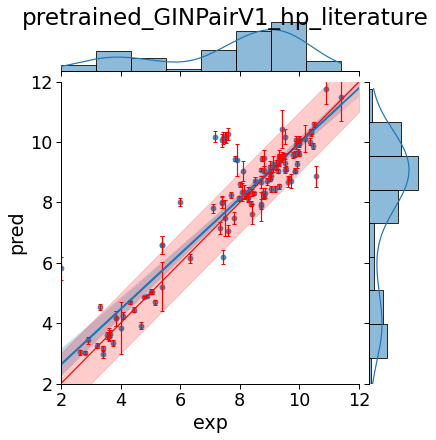

In [5]:
g = plot_results(x_array, y_array)
g.set_axis_labels("exp", "pred")
g.fig.suptitle(f"{name}")
g.ax_joint.text(
    1,
    0,
    stat_info,
    size="x-small",
    # ha="left",
    # va="top",
    ha="right",
    va="bottom",
    transform=g.ax_joint.transAxes,
)
# plt.savefig(f"{args.name}.pdf", bbox_inches="tight")